<a href="https://colab.research.google.com/github/fell100/Machine-Learning/blob/master/PokemonClassificator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [268]:
import os
import pandas as pd
from google.colab import drive
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline
from os import walk
import plotly.express as px
import cv2

Carregando os dados do Google Drive

In [269]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [270]:
#https://www.kaggle.com/datasets/vishalsubbiah/pokemon-images-and-types?select=pokemon.csv

In [271]:
DATA_DIR = '/content/gdrive/MyDrive/datasets/pokemon_classificator/pokemon_types'

In [272]:
csv_path = '/content/gdrive/MyDrive/datasets/pokemon_classificator/pokemon.csv'

# Analisando o dataset com os labels

In [273]:
pokemon_label_df = pd.read_csv(csv_path)
pokemon_label_df

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN
...,...,...,...
804,stakataka,Rock,Steel
805,blacephalon,Fire,Ghost
806,zeraora,Electric,NaN
807,meltan,Steel,NaN


In [274]:
pokemon_label_df.query("Type1 == 'Water'")

,Name,Type1,Type2
6,squirtle,Water,NaN
7,wartortle,Water,NaN
8,blastoise,Water,NaN
53,psyduck,Water,NaN
54,golduck,Water,NaN
...,...,...,...
750,dewpider,Water,Bug
751,araquanid,Water,Bug
770,pyukumuku,Water,NaN
778,bruxish,Water,Psychic


Observando os labels de cada classe e sua contagem

In [275]:
pokemon_label_df['Type1'].value_counts()

Water       114
Normal      105
Grass        78
Bug          72
Fire         53
Psychic      53
Rock         46
Electric     40
Poison       34
Ground       32
Dark         29
Fighting     29
Ghost        27
Dragon       27
Steel        26
Ice          23
Fairy        18
Flying        3
Name: Type1, dtype: int64

In [276]:
types = pokemon_label_df['Type1'].value_counts().keys()
count_types = pokemon_label_df['Type1'].value_counts().values
print(types)
print(count_types)

Index(['Water', 'Normal', 'Grass', 'Bug', 'Fire', 'Psychic', 'Rock',
       'Electric', 'Poison', 'Ground', 'Dark', 'Fighting', 'Ghost', 'Dragon',
       'Steel', 'Ice', 'Fairy', 'Flying'],
      dtype='object')
[114 105  78  72  53  53  46  40  34  32  29  29  27  27  26  23  18   3]


In [277]:
fig = px.bar(pokemon_label_df['Type1'], x = types, y = count_types, color = count_types)
fig.show()

In [278]:
types = pokemon_label_df['Type2'].value_counts().keys()
count_types = pokemon_label_df['Type2'].value_counts().values
print(types)
print(count_types)

fig = px.bar(pokemon_label_df['Type2'], x = types, y = count_types, color = count_types)
fig.show()

Index(['Flying', 'Poison', 'Ground', 'Fairy', 'Psychic', 'Fighting', 'Steel',
       'Grass', 'Dragon', 'Water', 'Dark', 'Ghost', 'Rock', 'Fire', 'Ice',
       'Electric', 'Bug', 'Normal'],
      dtype='object')
[95 32 32 29 29 25 23 19 18 17 17 16 14 11 11  8  5  4]


# Preparando as imagens em diretórios


In [279]:
path_exists = True
if not path_exists:
  for (dirpath, dirnames, filenames) in walk("/content/gdrive/MyDrive/datasets/pokemon_classificator/images/"):
    print("Directory path: ", dirpath)
    print("Folder name: ", dirnames)
    print("File name: ", filenames)
    
    #Criando as pastas de cada classe

    types = pokemon_label_df['Type1'].value_counts().keys()
    for poke_types in types:
      os.mkdir(DATA_DIR + poke_types)

    #Populando as pastas com os pokemons

    for image in filenames:
      x = image[:-4]
      poke_type = pokemon_label_df.query(f"Name == '{x}'")['Type1'].values[0]
      source = DATA_DIR + 'images/' + image
      destination = DATA_DIR + poke_type + '/' + image
      os.system(f'cp {source} {destination}')

else:
  print('Path Already exists on Drive')  

Path Already exists on Drive


In [280]:
source = DATA_DIR + 'images/' + 'abra.png'
source

'/content/gdrive/MyDrive/datasets/pokemon_classificator/pokemon_typesimages/abra.png'

# Definindo o transform e o Dataloader

In [281]:
transform = T.Compose([
            T.ToTensor()])

In [282]:
DATA_DIR

'/content/gdrive/MyDrive/datasets/pokemon_classificator/pokemon_types'

In [283]:
dataset = datasets.ImageFolder(DATA_DIR, transform=transform)

In [284]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [285]:
#img = dataloader.dataset[np.random.randint(0, (len(pokemon_label_df) - 1) )][0]
#plt.imshow(img.squeeze().permute(1,2,0));

In [286]:
data_dir = '/content/gdrive/MyDrive/datasets/pokemon_classificator/pokemon_types'

In [287]:
image_size = 50

In [288]:
from torchvision.transforms.transforms import CenterCrop
# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(120),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomPerspective(),
                                      transforms.CenterCrop((90,90)),
                                      transforms.Resize((image_size, image_size)),
                                      transforms.ToTensor()
                                      
                                      ,transforms.Normalize(mean = (0.485,0.456,0.406), std = (0.229, 0.224, 0.225))
                                       ])

test_transforms = transforms.Compose([#transforms.RandomRotation(30),
                                     #transforms.RandomResizedCrop(120),
                                      transforms.CenterCrop((90,90)),
                                      transforms.Resize((image_size, image_size)),
                                     transforms.ToTensor()
                                     ,transforms.Normalize(mean = (0.485,0.456,0.406), std = (0.229, 0.224, 0.225))
                                     ])

validation_transforms = transforms.Compose([#transforms.RandomRotation(30),
                                           #transforms.RandomResizedCrop(120),
                                            transforms.CenterCrop((90,90)),
                                            transforms.Resize((image_size, image_size)),
                                            transforms.ToTensor()
                                            ,transforms.Normalize(mean = (0.485,0.456,0.406), std = (0.229, 0.224, 0.225))
                                            ])


# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir, transform=train_transforms)
test_data = datasets.ImageFolder(data_dir, transform=test_transforms)
validation_data = datasets.ImageFolder(data_dir, transform=validation_transforms)

#train_data = torch.utils.data.SubsetRandomSampler()
#test_data = datasets.ImageFolder(data_dir, transform=test_transforms)
#validation_data = datasets.ImageFolder(data_dir, transform=validation_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=64)

In [289]:
testloader.dataset.classes

['Electric', 'Fire', 'Grass', 'Water']

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



torch.Size([64, 3, 50, 50])


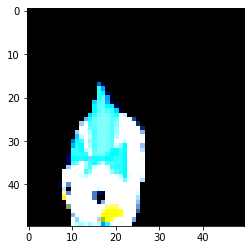

In [290]:
# Run this to test your data loader
images, labels = iter(trainloader).next()

# helper.imshow(images[0], normalize=False)
plt.imshow(images[23].squeeze().permute(1,2,0))
print(images.shape)

In [291]:
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Resize
import torch.optim as optim

In [292]:
def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

In [293]:
full_dataset = datasets.ImageFolder(data_dir, transform=train_transforms)
full_dataset = train_val_dataset(full_dataset, val_split = 0.30)

pokemon_train = full_dataset['train']
pokemon_test_val = full_dataset['val'] 

print(f'Train dataset length: {len(pokemon_train)}')
print(f'Test and validation datasets length: {len(pokemon_test_val)}')

Train dataset length: 199
Test and validation datasets length: 86


In [294]:
full_dataset = train_val_dataset(pokemon_test_val, val_split = 0.20)

pokemon_test = full_dataset['train']
pokemon_val = full_dataset['val'] 

print(f'Test dataset length: {len(pokemon_test)}')
print(f'Validation dataset length: {len(pokemon_val)}')

Test dataset length: 68
Validation dataset length: 18


In [295]:
train_loader = torch.utils.data.DataLoader(pokemon_train, batch_size=64)
test_loader = torch.utils.data.DataLoader(pokemon_test, batch_size=64)
validation_loader = torch.utils.data.DataLoader(pokemon_val, batch_size=64)

In [296]:
x,y = next(iter(trainloader))
print(x.shape, y.shape)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



torch.Size([64, 3, 50, 50]) torch.Size([64])


In [297]:
inputs = x.reshape(x.shape[0],-1)
inputs.shape

torch.Size([64, 7500])

# Definição do modelo e parâmetros

In [298]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [299]:
images.shape

torch.Size([64, 3, 50, 50])

In [300]:
learning_Rate = 0.0002
n_Inputs = images.shape[1] * images.shape[2] * images.shape[3]
n_Classes = len(pokemon_train.dataset.classes)
p_dropout = 0.5

model = torch.nn.Sequential(
    torch.nn.Linear(n_Inputs,4000),
    torch.nn.ReLU(),
    torch.nn.Dropout(p_dropout),

    torch.nn.Linear(4000,3000),
    torch.nn.ReLU(),
    torch.nn.Dropout(p_dropout),

    torch.nn.Linear(3000,3000),
    torch.nn.ReLU(),
    torch.nn.Dropout(p_dropout),

    torch.nn.Linear(3000,600),
    torch.nn.ReLU(),
    torch.nn.Dropout(p_dropout),

    torch.nn.Linear(600,n_Classes)
)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_Rate)
#optimizer = optim.SGD(model.parameters(), lr=learning_Rate, momentum=0.9)
print(model)

Sequential(
  (0): Linear(in_features=7500, out_features=4000, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4000, out_features=3000, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=3000, out_features=3000, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=3000, out_features=600, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.5, inplace=False)
  (12): Linear(in_features=600, out_features=4, bias=True)
)


Visualizando os tensores do modelo antes do treinamento

In [301]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[-0.0036,  0.0057, -0.0075,  ...,  0.0057, -0.0074, -0.0068],
        [-0.0049,  0.0074, -0.0070,  ..., -0.0022, -0.0011,  0.0055],
        [-0.0071,  0.0044,  0.0041,  ...,  0.0055,  0.0008,  0.0046],
        ...,
        [-0.0058, -0.0010, -0.0063,  ..., -0.0109,  0.0053, -0.0080],
        [-0.0018, -0.0105,  0.0044,  ...,  0.0043,  0.0060,  0.0061],
        [-0.0019,  0.0006,  0.0109,  ...,  0.0096,  0.0047, -0.0041]],
       requires_grad=True)
Parameter containing:
tensor([ 0.0068,  0.0020,  0.0056,  ..., -0.0106, -0.0017, -0.0111],
       requires_grad=True)
Parameter containing:
tensor([[-0.0079,  0.0016,  0.0138,  ...,  0.0047, -0.0129, -0.0112],
        [-0.0018,  0.0016,  0.0120,  ..., -0.0091,  0.0100,  0.0086],
        [-0.0113,  0.0038, -0.0152,  ..., -0.0019, -0.0068,  0.0035],
        ...,
        [-0.0019,  0.0024,  0.0076,  ...,  0.0071,  0.0136, -0.0086],
        [-0.0074, -0.0154, -0.0030,  ..., -0.0014,  0.0080,  0.0081],
        [-0.00

In [302]:
inputs = images.reshape(images.shape[0],-1)
outputs = model(inputs)
outputsClass = torch.argmax(outputs, dim=1)
accuracy = 100*(outputsClass==labels).sum()/len(labels)
print(accuracy)

tensor(25.)


# Treinando o Modelo

In [303]:
def train_model(nEpochs = 20):
  errors_train=[]
  errors_test=[]
  accuracy_test=[]
  for epoch in range(nEpochs):
    #carrega dados de lote
    train_loss=0
    for images, labels in train_loader:
    #images, labels = next(iter(trainloader))
      if torch.cuda.is_available():
        images.to('cuda')
        labels.to('cuda')
      #ajusta as dimensões
      model.train()
      inputs = images.reshape(images.shape[0],-1)
      #zera o gradiente
      optimizer.zero_grad()
      #propaga os dados na rede
      outputs = model(inputs)
      #calcula o erro
      
      #torch.nn.Dropout()
      loss = criterion(outputs, labels)
      train_loss+=loss.item()
      #calcula gradientes com backward

      loss.backward()
      #faz um passo de otimização
      
      optimizer.step()
      #calcula a acurácia
      model.eval()
      outputsClass = torch.argmax(outputs, dim=1)
      accuracy = (outputsClass==labels).sum()/len(labels)
      
      #usa os dados de fora do grupo de teste para fazer a validação

    with torch.no_grad():
      test_correct = 0
      test_loss=0
      for images, labels in validation_loader:
        if torch.cuda.is_available():
          images.to('cuda')
          labels.to('cuda')        
        inputs = images.reshape(images.shape[0],-1)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss+=loss.item()
        outputsClass = torch.argmax(outputs, dim=1)
        test_correct += (outputsClass==labels).sum()
    train_loss = train_loss/len(train_loader.dataset)
    test_loss = test_loss/len(validation_loader.dataset)
    errors_train.append(train_loss)
    errors_test.append(test_loss)
    print(f"Epochs: {epoch}, error train: {errors_train[-1]}, error test: {errors_test[-1]}")
    print(f'Accuracy {accuracy}')
    accuracy_test.append(accuracy)

  return errors_train, errors_test, accuracy_test

In [304]:
errors_train, errors_test, accuracy_test = train_model(50)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



Epochs: 0, error train: 0.02867274607845287, error test: 0.09694384204016791
Accuracy 0.4285714328289032
Epochs: 1, error train: 0.03157772490726644, error test: 0.0780680841869778
Accuracy 0.1428571492433548
Epochs: 2, error train: 0.029750055404164682, error test: 0.08249729209476048
Accuracy 0.4285714328289032
Epochs: 3, error train: 0.026778834848547702, error test: 0.09035121070014106
Accuracy 0.7142857313156128
Epochs: 4, error train: 0.028842362327192297, error test: 0.0972016387515598
Accuracy 0.5714285969734192
Epochs: 5, error train: 0.031651130872755194, error test: 0.10892183913124932
Accuracy 0.2857142984867096
Epochs: 6, error train: 0.0317644551770771, error test: 0.0895747873518202
Accuracy 0.5714285969734192
Epochs: 7, error train: 0.034311691121240356, error test: 0.08962255054050022
Accuracy 0.1428571492433548
Epochs: 8, error train: 0.03090256123087514, error test: 0.08437689807679918
Accuracy 0.1428571492433548
Epochs: 9, error train: 0.031145726616059115, error te

# Avaliando Resultados

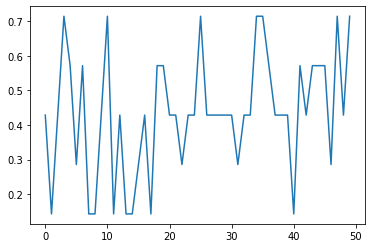

In [305]:
plt.plot(accuracy_test)

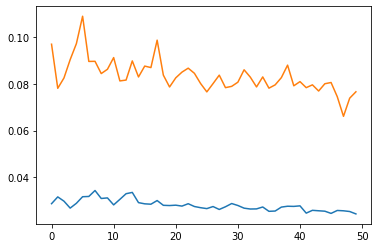

In [306]:
plt.plot(errors_train)
plt.plot(errors_test)

In [307]:
len(test_loader.dataset)

68

In [308]:
correct = 0
total = 0
correct_label = []
pred = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        correct_label += labels
        # calculate outputs by running images through the network
        #inputs = images.reshape(images.shape[0],-1)
        outputs = model(images.reshape(images.shape[0],-1))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        pred += predicted
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



Accuracy of the network on the test images: 47 %


In [309]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [310]:
accuracy_score(correct_label, pred)

0.47058823529411764

In [311]:
confusion_matrix(correct_label, pred)

array([[ 3,  0,  0,  3],
       [ 6,  0,  3,  4],
       [ 6,  0,  6, 10],
       [ 3,  0,  1, 23]])

In [312]:
print(classification_report(correct_label, pred))

              precision    recall  f1-score   support

           0       0.17      0.50      0.25         6
           1       0.00      0.00      0.00        13
           2       0.60      0.27      0.37        22
           3       0.57      0.85      0.69        27

    accuracy                           0.47        68
   macro avg       0.34      0.41      0.33        68
weighted avg       0.44      0.47      0.42        68



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [313]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        # calculate outputs by running images through the network
        #inputs = images.reshape(images.shape[0],-1)
        outputs = model(images.reshape(images.shape[0],-1))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the train images: {100 * correct // total} %')

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



Accuracy of the network on the train images: 40 %


In [314]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in validation_loader:
        images, labels = data
        # calculate outputs by running images through the network
        #inputs = images.reshape(images.shape[0],-1)
        outputs = model(images.reshape(images.shape[0],-1))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the validation images: {100 * correct // total} %')

Accuracy of the network on the validation images: 33 %


Visualizando os tensores do modelo após o treinamento

In [315]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[-3.6272e-03,  5.7986e-03, -7.4155e-03,  ...,  4.6495e-03,
         -8.6702e-03, -7.9092e-03],
        [-3.6228e-03,  8.7745e-03, -5.4646e-03,  ..., -9.3026e-04,
          2.7533e-06,  6.9322e-03],
        [-8.6053e-03,  2.9885e-03,  2.7133e-03,  ...,  7.7761e-03,
          3.0435e-03,  6.7723e-03],
        ...,
        [-5.7060e-03, -1.0136e-03, -6.4023e-03,  ..., -1.0778e-02,
          5.6586e-03, -7.7848e-03],
        [-2.9653e-03, -1.1707e-02,  3.1968e-03,  ...,  4.3790e-03,
          5.9423e-03,  6.1415e-03],
        [-4.5038e-04,  2.1123e-03,  1.2016e-02,  ...,  1.1900e-02,
          7.0941e-03, -1.9045e-03]], requires_grad=True)
Parameter containing:
tensor([ 7.4628e-03, -1.7310e-05,  5.1200e-03,  ..., -1.1929e-02,
        -3.6715e-03, -1.2189e-02], requires_grad=True)
Parameter containing:
tensor([[-0.0060,  0.0029,  0.0137,  ...,  0.0017, -0.0107, -0.0100],
        [-0.0042,  0.0051,  0.0105,  ..., -0.0116,  0.0082,  0.0062],
        [-0.0132,  0.

# Modelo inicializado com Zeros

In [316]:
learning_Rate = 0.0002
n_Inputs = images.shape[1] * images.shape[2] * images.shape[3]
n_Classes = len(pokemon_train.dataset.classes)
p_dropout = 0.5

model = torch.nn.Sequential(
    torch.nn.Linear(n_Inputs,4000),
    torch.nn.ReLU(),
    torch.nn.Dropout(p_dropout),

    torch.nn.Linear(4000,3000),
    torch.nn.ReLU(),
    torch.nn.Dropout(p_dropout),

    torch.nn.Linear(3000,3000),
    torch.nn.ReLU(),
    torch.nn.Dropout(p_dropout),

    torch.nn.Linear(3000,600),
    torch.nn.ReLU(),
    torch.nn.Dropout(p_dropout),

    torch.nn.Linear(600,n_Classes)
)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_Rate)
#optimizer = optim.SGD(model.parameters(), lr=learning_Rate, momentum=0.9)
print(model)

Sequential(
  (0): Linear(in_features=7500, out_features=4000, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4000, out_features=3000, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=3000, out_features=3000, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=3000, out_features=600, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.5, inplace=False)
  (12): Linear(in_features=600, out_features=4, bias=True)
)


In [317]:
@torch.no_grad()
def init_weights(m):
    print(m)
    if type(m) == nn.Linear:
        m.weight.fill_(0)
        #torch.nn.init.uniform_(tensor, a=0.0, b=1.0)
        print(m.weight)
model.apply(init_weights)

Linear(in_features=7500, out_features=4000, bias=True)
Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)
ReLU()
Dropout(p=0.5, inplace=False)
Linear(in_features=4000, out_features=3000, bias=True)
Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)
ReLU()
Dropout(p=0.5, inplace=False)
Linear(in_features=3000, out_features=3000, bias=True)
Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0

Sequential(
  (0): Linear(in_features=7500, out_features=4000, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4000, out_features=3000, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=3000, out_features=3000, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=3000, out_features=600, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.5, inplace=False)
  (12): Linear(in_features=600, out_features=4, bias=True)
)

In [318]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)
Parameter containing:
tensor([ 0.0025,  0.0037,  0.0082,  ..., -0.0092,  0.0051,  0.0036],
       requires_grad=True)
Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)
Parameter containing:
tensor([-0.0058, -0.0075, -0.0062,  ...,  0.0073,  0.0054, -0.0066],
       requires_grad=True)
Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 

In [319]:
errors_train, errors_test, accuracy_test = train_model(50)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



Epochs: 0, error train: 0.027818252093827905, error test: 0.07700610160827637
Accuracy 0.4285714328289032
Epochs: 1, error train: 0.027586458915442078, error test: 0.07549544175465901
Accuracy 0.4285714328289032
Epochs: 2, error train: 0.02648769012048616, error test: 0.0802212225066291
Accuracy 0.4285714328289032
Epochs: 3, error train: 0.026526759018251047, error test: 0.07732354270087348
Accuracy 0.4285714328289032
Epochs: 4, error train: 0.02612101252953611, error test: 0.07872700691223145
Accuracy 0.4285714328289032
Epochs: 5, error train: 0.02541284824735555, error test: 0.08437436156802708
Accuracy 0.4285714328289032
Epochs: 6, error train: 0.02600298095588109, error test: 0.0774223804473877
Accuracy 0.4285714328289032
Epochs: 7, error train: 0.02582659553642848, error test: 0.07511566744910346
Accuracy 0.4285714328289032
Epochs: 8, error train: 0.02506319961356158, error test: 0.07494874795277913
Accuracy 0.4285714328289032
Epochs: 9, error train: 0.025298474422052276, error te

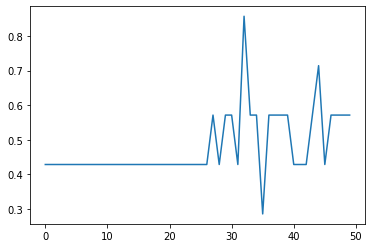

In [320]:
plt.plot(accuracy_test)

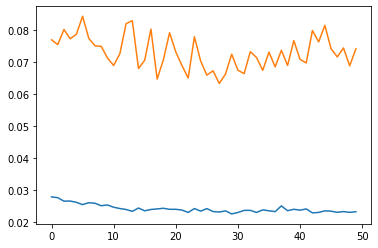

In [321]:
plt.plot(errors_train)
plt.plot(errors_test)

In [322]:
correct = 0
total = 0
correct_label = []
pred = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        correct_label += labels
        # calculate outputs by running images through the network
        #inputs = images.reshape(images.shape[0],-1)
        outputs = model(images.reshape(images.shape[0],-1))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        pred += predicted
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



Accuracy of the network on the test images: 47 %


In [323]:
accuracy_score(correct_label, pred)

0.47058823529411764

In [324]:
confusion_matrix(correct_label, pred)

array([[ 0,  3,  0,  3],
       [ 4,  4,  4,  1],
       [ 1,  3,  6, 12],
       [ 2,  3,  0, 22]])

In [325]:
print(classification_report(correct_label, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.31      0.31      0.31        13
           2       0.60      0.27      0.37        22
           3       0.58      0.81      0.68        27

    accuracy                           0.47        68
   macro avg       0.37      0.35      0.34        68
weighted avg       0.48      0.47      0.45        68



In [326]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        # calculate outputs by running images through the network
        #inputs = images.reshape(images.shape[0],-1)
        outputs = model(images.reshape(images.shape[0],-1))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the train images: {100 * correct // total} %')

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



Accuracy of the network on the train images: 46 %


In [327]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in validation_loader:
        images, labels = data
        # calculate outputs by running images through the network
        #inputs = images.reshape(images.shape[0],-1)
        outputs = model(images.reshape(images.shape[0],-1))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the validation images: {100 * correct // total} %')

Accuracy of the network on the validation images: 50 %


# Inicializando o modelo com uma distribuição uniforme entre -1 e 1

In [328]:
learning_Rate = 0.0002
n_Inputs = images.shape[1] * images.shape[2] * images.shape[3]
n_Classes = len(pokemon_train.dataset.classes)
p_dropout = 0.5

model = torch.nn.Sequential(
    torch.nn.Linear(n_Inputs,4000),
    torch.nn.ReLU(),
    torch.nn.Dropout(p_dropout),

    torch.nn.Linear(4000,3000),
    torch.nn.ReLU(),
    torch.nn.Dropout(p_dropout),

    torch.nn.Linear(3000,3000),
    torch.nn.ReLU(),
    torch.nn.Dropout(p_dropout),

    torch.nn.Linear(3000,600),
    torch.nn.ReLU(),
    torch.nn.Dropout(p_dropout),

    torch.nn.Linear(600,n_Classes)
)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_Rate)
#optimizer = optim.SGD(model.parameters(), lr=learning_Rate, momentum=0.9)
print(model)

Sequential(
  (0): Linear(in_features=7500, out_features=4000, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4000, out_features=3000, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=3000, out_features=3000, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=3000, out_features=600, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.5, inplace=False)
  (12): Linear(in_features=600, out_features=4, bias=True)
)


In [329]:
@torch.no_grad()
def init_weights(m):
    print(m)
    if type(m) == nn.Linear:
        m.weight.uniform_(-1, 1)
        #torch.nn.init.uniform_(tensor, a=0.0, b=1.0)
        print(m.weight)
model.apply(init_weights)

Linear(in_features=7500, out_features=4000, bias=True)
Parameter containing:
tensor([[ 1.7419e-01, -6.0418e-01, -3.5090e-02,  ..., -2.7185e-01,
          2.4343e-01, -3.3442e-01],
        [ 2.6368e-01,  2.1399e-01, -8.0393e-01,  ...,  5.1752e-01,
         -5.1818e-01,  1.4924e-01],
        [ 2.9544e-01, -3.0339e-04,  7.9364e-02,  ...,  6.2473e-01,
         -3.4632e-01, -8.2689e-01],
        ...,
        [-7.6789e-01,  4.9377e-01,  1.7904e-01,  ...,  5.0890e-01,
          3.2830e-02,  6.7301e-02],
        [ 9.1634e-01, -7.3883e-01, -7.2577e-01,  ...,  4.9096e-01,
          1.9384e-01, -2.1536e-01],
        [ 2.2110e-01,  9.2937e-01,  6.5989e-01,  ..., -6.5806e-01,
          7.9419e-01,  9.6296e-01]], requires_grad=True)
ReLU()
Dropout(p=0.5, inplace=False)
Linear(in_features=4000, out_features=3000, bias=True)
Parameter containing:
tensor([[ 0.7517,  0.8190, -0.9276,  ...,  0.6286, -0.3292, -0.1207],
        [ 0.9816,  0.9384,  0.3520,  ..., -0.5406, -0.2193,  0.9686],
        [-0.6027,

Sequential(
  (0): Linear(in_features=7500, out_features=4000, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4000, out_features=3000, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=3000, out_features=3000, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=3000, out_features=600, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.5, inplace=False)
  (12): Linear(in_features=600, out_features=4, bias=True)
)

In [330]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[ 1.7419e-01, -6.0418e-01, -3.5090e-02,  ..., -2.7185e-01,
          2.4343e-01, -3.3442e-01],
        [ 2.6368e-01,  2.1399e-01, -8.0393e-01,  ...,  5.1752e-01,
         -5.1818e-01,  1.4924e-01],
        [ 2.9544e-01, -3.0339e-04,  7.9364e-02,  ...,  6.2473e-01,
         -3.4632e-01, -8.2689e-01],
        ...,
        [-7.6789e-01,  4.9377e-01,  1.7904e-01,  ...,  5.0890e-01,
          3.2830e-02,  6.7301e-02],
        [ 9.1634e-01, -7.3883e-01, -7.2577e-01,  ...,  4.9096e-01,
          1.9384e-01, -2.1536e-01],
        [ 2.2110e-01,  9.2937e-01,  6.5989e-01,  ..., -6.5806e-01,
          7.9419e-01,  9.6296e-01]], requires_grad=True)
Parameter containing:
tensor([-0.0114, -0.0035,  0.0094,  ...,  0.0041,  0.0104,  0.0068],
       requires_grad=True)
Parameter containing:
tensor([[ 0.7517,  0.8190, -0.9276,  ...,  0.6286, -0.3292, -0.1207],
        [ 0.9816,  0.9384,  0.3520,  ..., -0.5406, -0.2193,  0.9686],
        [-0.6027, -0.4270, -0.4686,  ...,  0.2

In [331]:
errors_train, errors_test, accuracy_test = train_model(50)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



Epochs: 0, error train: 970473.3668341709, error test: 494229.0
Accuracy 0.2857142984867096
Epochs: 1, error train: 765909.8090452261, error test: 395363.47222222225
Accuracy 0.4285714328289032
Epochs: 2, error train: 733996.2512562814, error test: 306500.30555555556
Accuracy 0.4285714328289032
Epochs: 3, error train: 827069.8693467337, error test: 263582.5833333333
Accuracy 0.4285714328289032
Epochs: 4, error train: 848249.6482412061, error test: 171282.36111111112
Accuracy 0.2857142984867096
Epochs: 5, error train: 640805.9698492462, error test: 300383.0
Accuracy 0.4285714328289032
Epochs: 6, error train: 625976.2512562814, error test: 281925.3611111111
Accuracy 0.7142857313156128
Epochs: 7, error train: 759608.2814070352, error test: 278441.55555555556
Accuracy 0.0
Epochs: 8, error train: 823983.9095477387, error test: 325664.69444444444
Accuracy 0.1428571492433548
Epochs: 9, error train: 734862.2311557789, error test: 422432.5
Accuracy 0.4285714328289032
Epochs: 10, error train: 65

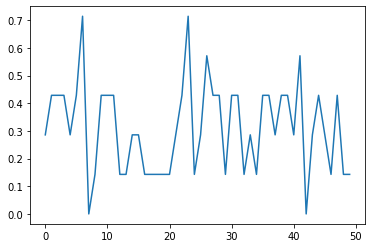

In [332]:
plt.plot(accuracy_test)

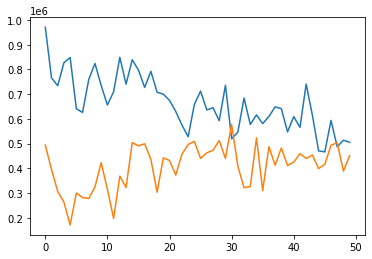

In [333]:
plt.plot(errors_train)
plt.plot(errors_test)

In [334]:
correct = 0
total = 0
correct_label = []
pred = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        correct_label += labels
        # calculate outputs by running images through the network
        #inputs = images.reshape(images.shape[0],-1)
        outputs = model(images.reshape(images.shape[0],-1))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        pred += predicted
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



Accuracy of the network on the test images: 44 %


In [335]:
accuracy_score(correct_label, pred)

0.4411764705882353

In [336]:
confusion_matrix(correct_label, pred)

array([[ 0,  0,  1,  5],
       [ 0,  2,  6,  5],
       [ 1,  3,  7, 11],
       [ 1,  2,  3, 21]])

In [337]:
print(classification_report(correct_label, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.29      0.15      0.20        13
           2       0.41      0.32      0.36        22
           3       0.50      0.78      0.61        27

    accuracy                           0.44        68
   macro avg       0.30      0.31      0.29        68
weighted avg       0.39      0.44      0.40        68



In [338]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        # calculate outputs by running images through the network
        #inputs = images.reshape(images.shape[0],-1)
        outputs = model(images.reshape(images.shape[0],-1))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the train images: {100 * correct // total} %')

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



Accuracy of the network on the train images: 41 %


In [339]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in validation_loader:
        images, labels = data
        # calculate outputs by running images through the network
        #inputs = images.reshape(images.shape[0],-1)
        outputs = model(images.reshape(images.shape[0],-1))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the validation images: {100 * correct // total} %')

Accuracy of the network on the validation images: 50 %
